# Load Libraries

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
from meteostat import Stations, Daily
from datetime import datetime
import pandas as pd
import geopandas as gpd
from meteostat import Stations, Daily
from datetime import datetime
import pandas as pd
import geopandas as gpd
from meteostat import Stations, Daily
from datetime import datetime
from shapely.geometry import Point
from geopy.distance import geodesic
import pandas as pd
from meteostat import Daily
from datetime import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import time
from shapely.geometry import Point
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Point
from tqdm import tqdm

# Download weather station data

In [ ]:
# Load GADM region boundaries for Greece
greece_regions = gpd.read_file(
    "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Data/gadm41_GRC_1.json"
)

# Fetch Greek weather stations
stations = Stations().region("GR").fetch()
stations_df = stations.reset_index()[['id', 'latitude', 'longitude']]

# Convert stations to GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['longitude'], stations_df['latitude']),
    crs=greece_regions.crs
)

# Spatially join stations to regions
stations_with_regions = gpd.sjoin(
    stations_gdf,
    greece_regions[['NAME_1', 'geometry']],
    predicate='intersects',
    how='inner'
).rename(columns={'NAME_1': 'region'})

# Define time period
start = datetime(2000, 1, 1)
end = datetime(2024, 12, 31)

weather_list = []
weather_columns = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']

for station_id in stations_with_regions['id'].unique():
    try:
        weather = Daily(station_id, start, end).fetch()[weather_columns]
        if not weather.empty:
            weather['station_id'] = station_id
            weather['date'] = weather.index
            weather.reset_index(drop=True, inplace=True)
            weather_list.append(weather)
    except Exception as e:
        print(f"Error fetching station {station_id}: {e}")

# Combine data
weather_df = pd.concat(weather_list, ignore_index=True)

# Merge with region data
weather_with_regions = weather_df.merge(
    stations_with_regions[['id', 'region']],
    left_on='station_id',
    right_on='id',
    how='left'
)

# Aggregate data by region and date
region_weather = weather_with_regions.groupby(['region', 'date']).agg({
    'tavg': 'mean',
    'tmax': 'mean',
    'tmin': 'mean',
    'prcp': 'mean',
    'snow': 'mean',
    'wdir': 'mean',
    'wspd': 'mean',
    'wpgt': 'mean',
    'pres': 'mean',
    'tsun': 'mean'
}).reset_index()

# Rename to your preferred columns
region_weather.rename(columns={
    'tavg': 'temp_avg',
    'tmax': 'temp_max',
    'tmin': 'temp_min',
    'prcp': 'precip',
    'snow': 'snow_depth',
    'wdir': 'wind_dir',
    'wspd': 'wind_speed',
    'wpgt': 'wind_gust',
    'pres': 'pressure',
    'tsun': 'sunshine_duration'
}, inplace=True)

# ----------- FILL MISSING REGION-DATE USING NEAREST REGION ----------- #

# Generate full region-date index
dates_full = pd.date_range(start=start, end=end)
regions = region_weather['region'].unique()
full_index = pd.MultiIndex.from_product([regions, dates_full], names=['region', 'date'])

# Reindex to introduce missing rows
region_weather_full = region_weather.set_index(['region', 'date']).reindex(full_index).reset_index()

# Project to metric CRS for accurate centroids
greece_regions['region'] = greece_regions['NAME_1']
greece_projected = greece_regions.to_crs(epsg=3857)
greece_regions['centroid'] = greece_projected['geometry'].centroid

# Convert back to lat/lon for distance calcs
greece_regions['centroid_coords'] = greece_regions['centroid'].to_crs(epsg=4326).apply(lambda g: (g.y, g.x))
region_coords = greece_regions.set_index('region')['centroid_coords'].to_dict()

# Fill missing rows using closest region with data on same date
filled_rows = []
for idx, row in region_weather_full[region_weather_full.isnull().any(axis=1)].iterrows():
    target_region = row['region']
    date = row['date']
    target_coord = region_coords.get(target_region)
    if not target_coord:
        continue

    available = region_weather_full[
        (region_weather_full['date'] == date) &
        (region_weather_full['region'] != target_region)
    ].dropna()

    if available.empty:
        continue

    available = available.copy()
    available['dist'] = available['region'].apply(lambda r: geodesic(target_coord, region_coords[r]).km)
    closest = available.sort_values('dist').iloc[0]
    filled_row = row.copy()
    filled_row.update(closest.drop(['region', 'date', 'dist']))
    filled_rows.append(filled_row)

# Merge back filled rows
filled_df = pd.DataFrame(filled_rows)
region_weather_final = pd.concat([
    region_weather_full.dropna(),
    filled_df
], ignore_index=True).sort_values(['region', 'date']).reset_index(drop=True)

# Save final dataset
region_weather_final.to_csv(
    "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Data/region_weather_2000_2024.csv",
    index=False
)

print(region_weather_final.head())




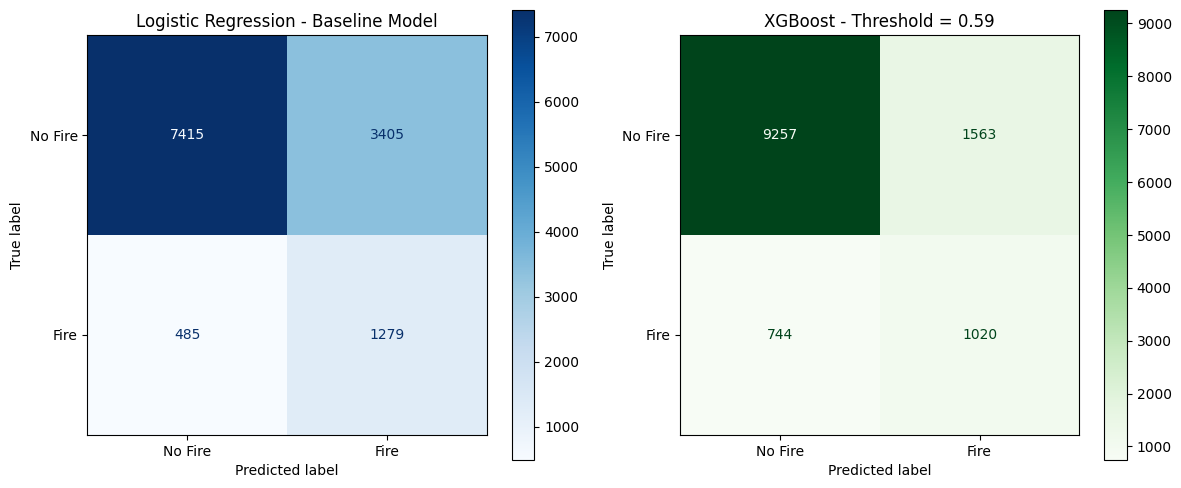

In [ ]:
# Assuming you have these ready:
# y_test, y_pred_baseline, y_pred_xgboost_final (after threshold 0.59)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_baseline,
    display_labels=["No Fire", "Fire"],
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("Logistic Regression - Baseline Model")

# Final XGBoost
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_adjusted, # (Threshold 0.59 predictions)
    display_labels=["No Fire", "Fire"],
    cmap="Greens",
    ax=axes[1]
)
axes[1].set_title("XGBoost - Threshold = 0.59")

plt.tight_layout()
plt.show()

In [20]:
region_weather['region'].value_counts()

region
Aegean                          9132
Crete                           9132
Peloponnese,WesternGreeceand    9132
MacedoniaandThrace              9126
Attica                          9117
ThessalyandCentralGreece        8882
EpirusandWesternMacedonia       4129
Name: count, dtype: int64

# Patch missing records, such they have weather information

In [ ]:

# List of fallback station IDs near Epirus
fallback_stations = [
    ('16642', 'Ioannina Airport'),
    ('16614', 'Kastoria Airport'),
    ('16632', 'Kozani Airport'),
    ('13629', 'Korca'),
    ('13625', 'Gjirokastra'),
    ('16613', 'Florina'),
    ('13580', 'Pretor-Pgc'),
    ('16641', 'Kerkyra Airport'),
    ('16648', 'Larissa Airport'),
    ('13583', 'Bitola')
]

# Define time range
start = datetime(2000, 1, 1)
end = datetime(2011, 9, 8)

# Placeholder for best patch
best_patch = None
best_station = None

# Try each fallback station
for station_id, station_name in fallback_stations:
    print(f"\n🔍 Trying station: {station_name} ({station_id})")
    try:
        patch_df = Daily(station_id, start, end).fetch()

        if not patch_df.empty:
            print(f"Data found: {patch_df.shape[0]} rows")

            patch_df['date'] = patch_df.index
            patch_df['region'] = 'EpirusandWesternMacedonia'
            patch_df.reset_index(drop=True, inplace=True)

            patch_df.rename(columns={
                'tavg': 'temp_avg',
                'tmax': 'temp_max',
                'tmin': 'temp_min',
                'prcp': 'precip',
                'snow': 'snow_depth',
                'wdir': 'wind_dir',
                'wspd': 'wind_speed',
                'wpgt': 'wind_gust',
                'pres': 'pressure',
                'tsun': 'sunshine_duration'
            }, inplace=True)

            patch_columns = ['region', 'date', 'temp_avg', 'temp_max', 'temp_min',
                             'precip', 'snow_depth', 'wind_dir', 'wind_speed',
                             'wind_gust', 'pressure', 'sunshine_duration']

            patch_df = patch_df[patch_columns]

            best_patch = patch_df
            best_station = station_name
            break  # Stop at first with data

        else:
            print("No data available.")

    except Exception as e:
        print(f"Error fetching station {station_id}: {e}")

# Merge with region_weather if data was found
if best_patch is not None:
    print(f"\n🚀 Using patch from: {best_station}")

    region_weather_patched = pd.concat([region_weather, best_patch], ignore_index=True)
    region_weather_patched.drop_duplicates(subset=['region', 'date'], keep='last', inplace=True)
    region_weather_patched = region_weather_patched.sort_values(['region', 'date']).reset_index(drop=True)

    region_weather_patched.to_csv(
        "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Data/region_weather_epirus_patched.csv",
        index=False
    )

    print("Final patched dataset saved.")
else:
    print("No suitable fallback station had data for the requested period.")


🔍 Trying station: Ioannina Airport (16642)
❌ No data available.

🔍 Trying station: Kastoria Airport (16614)
❌ No data available.

🔍 Trying station: Kozani Airport (16632)
❌ No data available.

🔍 Trying station: Korca (13629)
❌ No data available.

🔍 Trying station: Gjirokastra (13625)
❌ No data available.

🔍 Trying station: Florina (16613)
❌ No data available.

🔍 Trying station: Pretor-Pgc (13580)


❌ No data available.

🔍 Trying station: Kerkyra Airport (16641)
✅ Data found: 4269 rows

🚀 Using patch from: Kerkyra Airport
✅ Final patched dataset saved.


# Combining weather and fire events with elevation

chatgpt 4o, prompt: 

Write a full Python script that enriches a weather and wildfire event dataset by adding average terrain elevation for each region. The script should: (1) load a CSV file containing weather features, wildfire occurrence labels, and a ‘region’ column; (2) load a GeoJSON file containing geographic boundaries (polygons) for each region; (3) for each region, randomly sample approximately 150 latitude-longitude points inside the region’s polygon; (4) fetch elevation data for each sampled point using the Open-Elevation API (https://api.open-elevation.com/api/v1/lookup); (5) calculate the average elevation for each region; (6) merge the average elevation back into the original weather dataset based on the region; and (7) save the final enriched dataset to a new CSV file. The script should include retries for API calls, pause politely between requests (e.g., 0.2 seconds), print progress updates, and handle errors gracefully

This scripts adds terrain data to each record based on its region

In [ ]:
# --- CONFIG ---
# Paths
weather_file = "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/fire_events_with_weather.csv"
gadm_file = "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/gadm41_GRC_1.json"
output_file = "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/fire_events_with_weather_with_elevation.csv"

# Sampling settings
samples_per_region = 300  # Number of random points to sample per region

# API settings
api_url = "https://api.open-elevation.com/api/v1/lookup"
pause_between_calls = 0.2  # seconds

# --- LOAD DATA ---
print("Loading datasets...")
weather_df = pd.read_csv(weather_file)
gadm = gpd.read_file(gadm_file)
gadm = gadm.rename(columns={'NAME_1': 'region'})

# --- FUNCTION: Fetch elevation ---
def fetch_elevation(lat, lon, retries=3):
    for attempt in range(retries):
        try:
            response = requests.get(f"{api_url}?locations={lat},{lon}", timeout=10)
            if response.status_code == 200:
                result = response.json().get('results', [{}])[0]
                elevation = result.get('elevation')
                if elevation is not None:
                    return elevation
        except Exception:
            pass
        time.sleep(pause_between_calls)
    return None

# --- FUNCTION: Sample points inside polygon ---
def sample_points_in_polygon(polygon, num_points):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < num_points:
        random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(random_point):
            points.append((random_point.y, random_point.x))  # lat, lon
    return points

# --- MAIN: Calculate average, max, and min elevation per region ---
print("Sampling points and fetching elevations...")
region_elevations = []

for idx, row in tqdm(gadm.iterrows(), total=gadm.shape[0]):
    region_name = row['region']
    polygon = row['geometry']

    # Sample points
    points = sample_points_in_polygon(polygon, samples_per_region)

    # Fetch elevations
    elevations = []
    for lat, lon in points:
        elev = fetch_elevation(lat, lon)
        if elev is not None:
            elevations.append(elev)

    if elevations:
        avg_elevation = np.mean(elevations)
        max_elevation = np.max(elevations)
        min_elevation = np.min(elevations)
    else:
        avg_elevation = np.nan
        max_elevation = np.nan
        min_elevation = np.nan

    region_elevations.append((region_name, avg_elevation, max_elevation, min_elevation))

# --- BUILD DATAFRAME ---
print("Building region elevation dataframe...")
region_elevation_df = pd.DataFrame(region_elevations, columns=['region', 'avg_elevation', 'max_elevation', 'min_elevation'])

# --- MERGE into weather dataset ---
print("Merging elevation into weather dataset...")
weather_df = weather_df.merge(region_elevation_df, on='region', how='left')

# --- SAVE ---
weather_df.to_csv(output_file, index=False)
print(f"Saved enriched dataset to: {output_file}")




Loading datasets...
Sampling points and fetching elevations...


100%|██████████| 8/8 [08:30<00:00, 63.82s/it]


Building region elevation dataframe...
Merging elevation into weather dataset...
Saved enriched dataset to: /Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/fire_events_with_weather_with_elevation.csv


In [10]:
df = pd.read_csv("/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/fire_events_with_weather_with_elevation.csv")

In [11]:
df.head() 

,region,date,temp_avg,temp_max,temp_min,precip,snow_depth,wind_dir,wind_speed,wind_gust,pressure,sunshine_duration,wildfire_count,wildfire_occurred,avg_elevation,max_elevation,min_elevation
0,Aegean,2000-01-01,12.325000,14.850000,10.900000,7.1,NaN,309.0,17.333333,NaN,NaN,NaN,0,0,201.19,988.0,0.0
1,Aegean,2000-01-02,10.475000,11.700000,8.800000,0.0,NaN,192.5,16.566667,NaN,NaN,NaN,0,0,201.19,988.0,0.0
2,Aegean,2000-01-03,7.066667,8.733333,4.933333,1.3,NaN,184.5,33.950000,NaN,NaN,NaN,0,0,201.19,988.0,0.0
3,Aegean,2000-01-04,6.350000,7.500000,5.250000,0.0,NaN,330.0,36.200000,NaN,NaN,NaN,0,0,201.19,988.0,0.0
4,Aegean,2000-01-05,6.500000,8.533333,3.466667,0.0,NaN,317.0,21.050000,NaN,NaN,NaN,0,0,201.19,988.0,0.0


In [12]:
region_elevation = df[['region', 'avg_elevation','max_elevation', 'min_elevation']].drop_duplicates()

# Sort for better viewing
region_elevation = region_elevation.sort_values('avg_elevation', ascending=False)

print(region_elevation)

                             region  avg_elevation  max_elevation  \
27381     EpirusandWesternMacedonia     841.143333         2200.0   
44905  Peloponnese,WesternGreeceand     489.623333         1965.0   
54037      ThessalyandCentralGreece     484.766667         1979.0   
18249                         Crete     470.780000         2148.0   
35779            MacedoniaandThrace     382.493333         2205.0   
9132                         Attica     261.163333         1071.0   
0                            Aegean     201.190000          988.0   

       min_elevation  
27381           -5.0  
44905           -2.0  
54037            0.0  
18249           -2.0  
35779           -3.0  
9132             0.0  
0                0.0  


# Merging datasets

In [ ]:
# SCRIPT: Merge MODIS Fires with Enriched Weather + Terrain Dataset

import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Point
from tqdm import tqdm

# --- CONFIG ---


# --- LOAD DATA ---
print("Loading datasets...")
weather_df = pd.read_csv(weather_file)
weather_df['date'] = pd.to_datetime(weather_df['date'])

modis_df = pd.read_csv(modis_file)
modis_df['acq_date'] = pd.to_datetime(modis_df['acq_date'])

gadm = gpd.read_file(gadm_file)
gadm = gadm.rename(columns={'NAME_1': 'region'})

# --- Spatial join: Assign MODIS fires to regions ---
print("Assigning fires to regions...")
modis_gdf = gpd.GeoDataFrame(
    modis_df,
    geometry=gpd.points_from_xy(modis_df['longitude'], modis_df['latitude']),
    crs=gadm.crs
)

modis_with_region = gpd.sjoin(
    modis_gdf,
    gadm[['region', 'geometry']],
    how='inner',
    predicate='intersects'
).drop(columns=['index_right'])

# --- Standardize column names ---
modis_with_region.rename(columns={'acq_date': 'date'}, inplace=True)
modis_with_region['date'] = pd.to_datetime(modis_with_region['date'])

# --- Aggregate fires per region and date ---
print("Aggregating fire counts...")
fire_counts = modis_with_region.groupby(['region', 'date']).size().reset_index(name='wildfire_count')
fire_counts['wildfire_occurred'] = 1

# --- Merge fire counts into enriched weather dataset ---
print("Merging fire data with weather + terrain data...")
weather_labeled = weather_df.merge(fire_counts, on=['region', 'date'], how='left')

# --- Ensure wildfire_occurred and wildfire_count columns exist and are safe ---
for col in ['wildfire_occurred', 'wildfire_count']:
    if col not in weather_labeled.columns:
        weather_labeled[col] = 0
    else:
        weather_labeled[col] = weather_labeled[col].fillna(0).astype(int)

# --- SAVE FINAL DATASET ---
weather_labeled.to_csv(output_file, index=False)
print(f"Final enriched dataset saved to: {output_file}")

Loading datasets...
Assigning fires to regions...
Aggregating fire counts...
Merging fire data with weather + terrain data...
Final enriched dataset saved to: /Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/final_fire_weather_with_elevation.csv


In [ ]:


# --- CONFIG ---
weather_file = "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/fire_events_with_weather_with_elevation.csv"
modis_file = "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/fire_archive_M-C61_586436.csv"
gadm_file = "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/gadm41_GRC_1.json"
output_file = "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/final_fire_weather_with_elevation.csv"

# --- LOAD DATA ---
print("Loading datasets...")
weather_df = pd.read_csv(weather_file)
weather_df['date'] = pd.to_datetime(weather_df['date'])

modis_df = pd.read_csv(modis_file)
modis_df['acq_date'] = pd.to_datetime(modis_df['acq_date'])

gadm = gpd.read_file(gadm_file)
gadm = gadm.rename(columns={'NAME_1': 'region'})

# --- FILTER MODIS FIRES BY CONFIDENCE ---
print("Filtering MODIS fires by confidence ≥ 30...")
modis_filtered = modis_df[modis_df['confidence'] >= 30]

# --- Spatial join: Assign MODIS fires to regions ---
print("Assigning fires to regions...")
modis_gdf = gpd.GeoDataFrame(
    modis_filtered,
    geometry=gpd.points_from_xy(modis_filtered['longitude'], modis_filtered['latitude']),
    crs=gadm.crs
)

modis_with_region = gpd.sjoin(
    modis_gdf,
    gadm[['region', 'geometry']],
    how='inner',
    predicate='intersects'
).drop(columns=['index_right'])

# --- Standardize column names ---
modis_with_region.rename(columns={'acq_date': 'date'}, inplace=True)
modis_with_region['date'] = pd.to_datetime(modis_with_region['date'])

# --- Aggregate fires per region and date ---
print("Aggregating fire counts...")
fire_counts = modis_with_region.groupby(['region', 'date']).size().reset_index(name='wildfire_count')
fire_counts['wildfire_occurred'] = 1

# --- Merge fire counts into enriched weather dataset ---
print("Merging fire data with weather + terrain data...")
weather_labeled = weather_df.merge(fire_counts, on=['region', 'date'], how='left')

# --- Ensure wildfire_occurred and wildfire_count columns exist and are safe ---
for col in ['wildfire_occurred', 'wildfire_count']:
    if col not in weather_labeled.columns:
        weather_labeled[col] = 0
    else:
        weather_labeled[col] = weather_labeled[col].fillna(0).astype(int)

# --- SAVE FINAL DATASET ---
weather_labeled.to_csv(output_file, index=False)
print(f"Final enriched dataset saved to: {output_file}")

Loading datasets...
Filtering MODIS fires by confidence ≥ 30...
Assigning fires to regions...
Aggregating fire counts...
Merging fire data with weather + terrain data...
Final enriched dataset saved to: /Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/final_fire_weather_with_elevation.csv
